# ***Deep Learning - Assignment 1***

Student name - Leor Ariel Rose, ID - 208373365

Student name - Aviv Rovshitz, ID - 307974162

### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
import numpy as np
from typing import List, Dict, Tuple # For type hinting
from tensorflow import keras # For mnist dataset
from tensorflow.keras.utils import to_categorical # For one hot encoding
from matplotlib import pyplot as plt # For cost visualization

np.random.seed(0) # For randomness

### ***Constant defintations***

Next, Let's define some constant variables:

In [2]:
EPSILON = 1e-14
EARLY_STOPPING_EPSILON = 1e-4
KEEP_PROB = 0.8

### ***Part 1 - Forward propagation process***

Next, lets create all foward propagation functionality:

In [3]:
def initialize_parameters(layer_dims: List[int]) -> Dict[str, np.ndarray]:
    """ Function to initialize W and b parameters of each layer.

    Args:
        layer_dims (List[int]): An array of the dimensions of each layer in the
            network (layer 0 is the size of the flattened input, layer L is the
            output softmax)

    Returns:
        Dict[str, np.ndarray]: A dictionary containing the initialized W and b
            parameters of each layer (W1…WL, b1…bL).

    """
    # Initialize empty dict to contain W and b
    parameters = {}
    # Loop over each layer 
    for i in range(1, len(layer_dims)):
        # Initialize W using He initialization
        parameters[f"W{i}"] = np.random.randn(
            layer_dims[i], layer_dims[i-1]) * np.sqrt(2/layer_dims[i-1])
        # Initialize b to constant zero 
        parameters[f"b{i}"] = np.zeros((layer_dims[i], 1))
    return parameters


def linear_forward(A: np.ndarray, W: np.ndarray,
                   b: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """ Function to apply the linear part of a layer's forward propagation.

    Args:
        A (np.ndarray): The activations of the previous layer (of shape 
            [size of previous layer, number of examples])
        W (np.ndarray): The weight matrix of the current layer (of shape
            [size of current layer, size of previous layer])
        b (np.ndarray): The bias vector of the current layer (of shape
            [size of current layer, 1])

    Returns:
        (Tuple[np.ndarray, Dict[str, np.ndarray]]): First element is the linear
            component of the activation function (i.e., the value before
            applying the non-linear function). Second element is a dictionary
            containing A, W, b (stored for making the backpropagation easier
            to compute)

    """
    # Calculate linear component of the activation function
    Z = np.dot(W, A) + b
    return Z, {"A": A, "W": W, "b": b}


def softmax(Z: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """ Function to apply softmax activation.

    Args:
        Z (np.ndarray): The linear component of the activation function

    Returns:
        (Tuple[np.ndarray, Dict[str, np.ndarray]]): First element is the
            activations of the layer. Second element is a dictionary containing
            Z (stored for making the backpropagation easier to compute)

    """
    # Subtract max for numerically stable exponential
    exp_max = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    # Apply softmax
    A = exp_max / np.sum(exp_max, axis=0, keepdims=True)
    return A, {"Z": Z}


def relu(Z: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """ Function to apply relu activation.

    Args:
        Z (np.ndarray): The linear component of the activation function

    Returns:
        (Tuple[np.ndarray, Dict[str, np.ndarray]]): First element is the
            activations of the layer. Second element is a dictionary containing
            Z (stored for making the backpropagation easier to compute)

    """
    # Apply relu
    A = np.maximum(0, Z)
    return A, {"Z": Z}


def linear_activation_forward(
    A_prev: np.ndarray, W: np.ndarray, B: np.ndarray,
    activation: str) -> Tuple[np.ndarray, Dict[str, Dict[str, np.ndarray]]]:
    """ Function to apply the forward propagation for the LINEAR -> 
    ACTIVATION layer.

    Args:
        A_prev (np.ndarray): Activations of the previous layer
        W (np.ndarray): The weights matrix of the current layer
        B (np.ndarray): The bias vector of the current layer
        activation (str): The activation function to be used (a string,
            either "softmax" or "relu")

    Returns:
        (Tuple[np.ndarray, Dict[str, Dict[str, np.ndarray]]]): First element is
            the activations of the current layer. Second element is a
            dictionary containing linear_cache and activation_cache (stored 
            for making the backpropagation easier to compute)

    """
    # Get activation function from activation string
    activation_func = softmax if activation == "softmax" else relu
    # Apply linear part of a layer's forward propagation
    Z, linear_cache = linear_forward(A_prev, W, B)
    # Apply activation part of a layer's forward propagation
    A, activation_cache  = activation_func(Z)
    return A, {'linear_cache': linear_cache, 
               'activation_cache': activation_cache}


def L_model_forward(
    X: np.ndarray, parameters: Dict[str, np.ndarray],
    use_batchnorm: bool, use_dropout: bool = False
    ) -> Tuple[np.ndarray, List[Dict[str, Dict[str, np.ndarray]]]]:
    """ Function to apply forward propagation for the 
    [LINEAR -> RELU] * (L-1) -> LINEAR -> SOFTMAX computation.
    
    Args:
        X (np.ndarray): The data (of shape [input size, number of examples])
            parameters (Dict[str, np.ndarray]): The initialized W and b
            parameters of each layer
        use_batchnorm (bool): A boolean flag used to determine whether
            to apply batchnorm after the activation
        use_dropout (bool): A boolean flag used to determine whether
            to apply dropout. Defaults to False

    Returns:
        (Tuple[np.ndarray, List[Dict[str, Dict[str, np.ndarray]]]]): A list of
            all the cache objects generated by the linear_forward function

    """
    # Get number of layers 
    num_layers = len(parameters) // 2
    # Initialize empty list to contain caches
    caches = []
    # Initialize first A for loop
    A = X
    # Loop over each not including last layer because relu and softmax
    # activations
    for i in range(1, num_layers):
        # Apply linear activation part of a layer's forward propagation
        A, cache = linear_activation_forward(A, parameters[f"W{i}"],
                                             parameters[f"b{i}"], "relu")
        # Apply batchnorm
        if use_batchnorm:
            A = apply_batchnorm(A)

        # Apply dropout
        if use_dropout:
            D = np.random.rand(A.shape[0], A.shape[1]) < KEEP_PROB
            A = np.multiply(A, D)
            A /= KEEP_PROB
            cache["dropout"] = {"D" : D}

        # Add linear_cache and activation_cache to list
        caches.append(cache)
    
    # Apply linear activation part of a layer's forward propagation
    AL, cache = linear_activation_forward(
        A, parameters[f"W{num_layers}"],
        parameters[f"b{num_layers}"], "softmax")
    # Add linear_cache and activation_cache to list
    caches.append(cache)
    return AL, caches


def compute_cost(AL: np.ndarray, Y: np.ndarray) -> float:
    """ Function to calculate categorical cross-entropy loss

    Args:
         X (np.ndarray): Probability vector corresponding to your label
            predictions, shape (num_of_classes, number of examples).
         Y (np.ndarray): the labels vector shape (num_of_classes,
            number of examples)
    
    Returns:
        (float): The cross-entropy cost

    """
    # Clipping Labels
    k = AL.shape[0]
    Y_clipped = np.clip(Y, (EPSILON / k) , 1. - (EPSILON * ((k-1)/k)))
    # Get number of examples
    m = AL.shape[1]
    # Calculate cost
    cost = -np.sum((Y_clipped * np.log(AL + EPSILON))) / m
    return cost


def apply_batchnorm(A: np.ndarray) -> np.ndarray:
    """ Function to apply batchnorm.

    Args:
        A (np.ndarray): The activation values of a given layer

    Returns:
        (np.ndarray): The normalized activation values
    """
    # Calculate mean, std, var
    sample_mean  = A.mean(axis=0, keepdims=True)
    sample_var  = A.var(axis=0, keepdims=True)
    std = np.sqrt(sample_var + EPSILON)

    # normalize
    A_centered = A - sample_mean
    A_norm = A_centered / std
    return A_norm

### ***Part 2 - Backward propagation process***
Next, lets create all backward propagation functionality:

In [4]:
def Linear_backward(dZ: np.ndarray,
                    cache: Tuple[np.ndarray, np.ndarray, np.ndarray]
                    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Function to apply the linear part of the backward propagation
    process for a single layer.

    Args:
        dZ (np.ndarray): The gradient of the cost with respect to the linear
            output of the current layer (layer l)
        cache (Tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple of values 
            (A_prev, W, b) coming from the forward propagation in the current
            layer

    Returns:
        (Tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple of values - 
            dA_prev, dW, db. dA_prev is the gradient of the cost with 
            respect to the activation (of the previous layer l-1), dW is the 
            gradient of the cost with respect to W (current layer l), db is the
            gradient of the cost with respect to b (current layer l)

    """
    # Unpack chache
    A_prev, W, b = cache
    # Get number of examples
    m = A_prev.shape[1]
    # Calculate gradient of the cost with respect to the activation
    dA_prev = np.dot(W.T, dZ)
    # Calculate gradient of the cost with respect to the W
    dW = (1.0 / m) * np.dot(dZ, A_prev.T)
    # Calculate gradient of the cost with respect to the b
    db = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)
    return (dA_prev, dW, db)


def linear_activation_backward(
    dA: np.ndarray, cache: Dict[str, Dict[str, np.ndarray]],
    activation: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Function to apply the backward propagation for the LINEAR ->
    ACTIVATION layer.

    Args:
        dA (np.ndarray): Post activation gradient of the current layer
        cache (Dict[str, Dict[str, np.ndarray]]): Linear cache and the 
            activations cache
        activation (str): The activation function to be used (a string,
            either "softmax" or "relu")

    Returns:
        (Tuple[np.ndarray, np.ndarray, np.ndarray]): Tuple of values - 
            dA_prev, dW, db. dA_prev is the gradient of the cost with 
            respect to the activation (of the previous layer l-1), dW is the 
            gradient of the cost with respect to W (current layer l), db is the
            gradient of the cost with respect to b (current layer l)

    """
    # Unpack linear_cache
    A_prev = cache['linear_cache']['A']
    W = cache['linear_cache']['W']
    b = cache['linear_cache']['b']
    # Get backward activation function from activation string
    activation_func_backward = (
        softmax_backward if activation == "softmax" else relu_backward)
    # Calculate gradient of the cost with respect to the linear
    # output of the current layer
    dZ = activation_func_backward(dA, cache['activation_cache'])
    return Linear_backward(dZ, (A_prev, W, b))


def relu_backward(dA: np.ndarray, activation_cache: Dict[str, np.ndarray]
                  ) -> np.ndarray:
    """ Function to apply backward propagation for a relu unit
    
    Args:
        dA (np.ndarray): Post activation gradient
        activation_cache (Dict[str, np.ndarray]): Activation cache, contains Z 
            (stored during the forward propagation)

    Returns:
        (np.ndarray): Gradient of the cost with respect to Z

    """
    # Get Z
    Z = activation_cache['Z']
    # Calculate gradient of the cost with respect to Z
    dZ = dA * (Z >= 0)
    return dZ


def softmax_backward(dA: np.ndarray, activation_cache: Dict[str, np.ndarray]
                     ) -> np.ndarray:
    """ Function to apply backward propagation for a softmax unit
    
    Args:
        dA (np.ndarray): Post activation gradient
        activation_cache (Dict[str, np.ndarray]): Activation cache, contains Z 
            (stored during the forward propagation)

    Returns:
        (np.ndarray): Gradient of the cost with respect to Z

    """
        # Get Z
    Z = activation_cache['Z']
    # Calculate gradient of the cost with respect to Z
    dZ = softmax(Z)[0] - dA
    return dZ


def L_model_backward(AL: np.ndarray, Y: np.ndarray,
                     caches: List[Dict[str, Dict[str, np.ndarray]]],
                     use_dropout: bool=False) -> Dict[str, np.ndarray]:
    """ Function to apply the backward propagation process for the entire
    network.

    Args:
        AL (np.ndarray): The probabilities vector, the output of the forward
            propagation (L_model_forward)
        Y (np.ndarray): The true labels vector
        caches (List[Dict[str, Dict[str, np.ndarray]]]): List of caches 
            containing for each layer the linear cache and he activation cache
        use_dropout (bool): A boolean flag used to determine whether
            to apply dropout

    Returns:
        (Dict[str, np.ndarray]): A dictionary with the gradients

    """

    # Initialize empty dict for gradients
    grads = {}
    # Get number of layers
    num_layers = len(caches)
    
    # Apply backward propagation for linear activation for last layer
    dA_prev, dW, db = linear_activation_backward(Y, caches[num_layers-1],
                                                 "softmax")
    grads[f"dA{num_layers}"] = dA_prev
    grads[f"dW{num_layers}"] = dW
    grads[f"db{num_layers}"] = db
    
    # Loop over each not including last layer
    for i in reversed(range(num_layers - 1)):
        dA_prev = grads[f"dA{i + 2}"]
        
        # Apply dropout
        if use_dropout:
            dA_prev = np.multiply(dA_prev, caches[i]["dropout"]["D"])

        # Apply backward propagation for linear activation
        dA_prev, dW, db = linear_activation_backward(dA_prev,
                                                     caches[i], "relu")
        grads[f"dA{i + 1}"] = dA_prev
        grads[f"dW{i + 1}"] = dW
        grads[f"db{i + 1}"] = db
    return grads


def Update_parameters(parameters: Dict[str, np.ndarray],
                      grads: Dict[str, np.ndarray], learning_rate: float
                      )-> Dict[str, np.ndarray]:
    """ Function to Update parameters using gradient descent

    Args:
        parameters (Dict[str, np.ndarray]): Architecture’s parameters
        grads (Dict[str, np.ndarray]): Gradients (generated by L_model_backward)
        learning_rate (float): Learning rate used to update the parameters 

    Returns:
        (Dict[str, np.ndarray]): the updated values of the parameters object
            provided as input

    """
    # get number of layers
    num_layers = len(parameters) // 2

    # Loop over each layer
    for i in range(1, num_layers + 1):
        # Update W
        parameters[f"W{i}"] -= learning_rate * grads[f"dW{i}"]
        # Update b
        parameters[f"b{i}"] -= learning_rate * grads[f"db{i}"]
    return parameters

### ***Part 3 - Combining forward and backward propagation process***

Next, let's combine the forward and Backward propagation functionality we created in order to create a to trainable network and produce predictions:

In [5]:
def L_layer_model(X: np.ndarray, Y: np.ndarray, layers_dims: List[int],
                  learning_rate: float, num_iterations: int, batch_size: int,
                  use_batchnorm: bool=False, use_dropout: bool=False,
                  validation_split: float = 0.2, shuffle:bool=True
                  ) -> Tuple[List[Tuple[float, float]], Dict[str, np.ndarray]]:
    """ Function to create and train a L-layer neural network.

    Args:
        X (np.ndarray): The input data (of shape [examples_size ,
            number_of_examples])
        Y (np.ndarray): The "real" labels of the data (of shape 
            [num_of_classes, number of examples])
        layers_dims (List[int]): A list containing the dimensions of each
            layer, including the input
        learning_rate (float): Learning rate used to update the parameters 
        num_iterations (int): the number training iterations
        batch_size (int): the number of examples in a single training batch
        use_batchnorm (bool): A boolean flag used to determine whether
            to apply batchnorm after the activation
        use_dropout (bool): A boolean flag used to determine whether
            to apply dropout
        validation_split (float): Float between 0 and 1. Fraction of the
            training data to be used as validation data
        shuffle (bool): A boolean flag used to determine whether to shuffle the
            training data before each epoch
    Returns:
        Tuple[List[float], Dict[str, np.ndarray]]: First element is the 
            parameters learnt by the system during the training, Second
            element is the values of the cost function (One value is to be 
            saved after each 100 training iterations)

    """    
    # Initialize empty list for costs
    costs = []

    # Create validation and training set
    stack = np.hstack((X.T, Y.T))
    np.random.shuffle(stack)
    stack_size = int(np.floor(stack.shape[0] * validation_split))
    stack_train = stack[stack_size:]
    stack_val = stack[:stack_size]
    X_Val = stack_val[:, :X.shape[0]].T
    Y_Val = stack_val[:, X.shape[0]:].T
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    # Keep track of number of batch
    batch_i = 0
    # track previous epoch val cost for early stopping
    prev_epoch_val_cost = np.Inf

    # loop over each epoch
    for epoch in range(1, num_iterations + 1):
        # Initialize list for storing all loss
        epoch_cost = []
        # Initialize list for storing all accuarcy
        epoch_acc = []
        # Shuffle X_train and Y_train together
        if shuffle:
            np.random.shuffle(stack_train)
        # Loop over batches
        for batch in split_given_size(stack_train, batch_size):
            # Get batch X and transpose it
            X_batch = batch[:, :X.shape[0]].T
            # Get batch Y and transpose it
            Y_batch = batch[:, X.shape[0]:].T
            # Forward propagation
            AL, caches = L_model_forward(X_batch, parameters,
                                         use_batchnorm, use_dropout)
            # Compute cost + track iteration cost
            cost = compute_cost(AL, Y_batch)
            epoch_cost.append(cost)
            if batch_i % 100 == 0:
                # Calculate Validation loss and accuracy
                np.random.shuffle(stack_val)
                batch_AL_val, _ = L_model_forward(
                    X_Val, parameters, use_batchnorm, False)
                batch_val_cost = compute_cost(batch_AL_val, Y_Val)
                costs.append((cost, batch_val_cost))
            batch_i += 1
            # compute accuracy + track iteration accuracy
            epoch_acc.append(Predict(X_batch, Y_batch, parameters,
                                     use_batchnorm))
            # Backward propagation
            grads = L_model_backward(AL, Y_batch, caches, use_dropout)
            # Update parameters based on gradients
            parameters = Update_parameters(parameters, grads, learning_rate)
        
        # Calculate Validation loss and accuracy
        AL_val, _ = L_model_forward(X_Val, parameters, use_batchnorm, False)
        epoch_val_cost = compute_cost(AL_val, Y_Val)
        epoch_val_acc = Predict(X_Val, Y_Val, parameters, use_batchnorm)

        # Calculate Train loss and accurcy
        epoch_train_cost = np.mean(epoch_cost)
        epoch_train_acc = np.mean(epoch_acc)
        
        # Print epoch information
        print((f"Epoch (Training step) #{epoch} | train_loss: "
            f"{epoch_train_cost:.4f} - val_loss: {epoch_val_cost:.4f} | "
            f"train_acc: {(epoch_train_acc*100):.4f}% - "
            f"val_acc: {(epoch_val_acc*100):.4f}%"))

        # Check if we need to early stop
        if  prev_epoch_val_cost - epoch_val_cost < EARLY_STOPPING_EPSILON:
            print("Early stopping!")
            print((f"Training has completed after {batch_i} iterations and "
            f"{epoch} epochs (training steps)!"))
            return costs, parameters

        # Update
        prev_epoch_val_cost = epoch_val_cost
    print((f"Training has completed after {batch_i} iterations steps and "
        f"{num_iterations + 1} epochs (training steps)!"))
    return costs, parameters


def Predict(X: np.ndarray, Y: np.ndarray,
            parameters: Dict[str, np.ndarray], use_batchnorm: bool=False
            ) -> float:
    """ Function to calculate the accuracy of the trained neural network on 
        the data.

    Args:
        X (np.ndarray): The input data (of shape [examples_size ,
            number_of_examples])
        Y (np.ndarray): The "real" labels of the data (of shape 
            [num_of_classes, number of examples])
        Parameters (Dict[str, np.ndarray]): Architecture’s parameters
        use_batchnorm (bool): A boolean flag used to determine whether
            to apply batchnorm after the activation

    Returns:
        (float): The accuracy of the trained neural network on 
        the data

    """  
    # Forward propagation
    prob, caches = L_model_forward(X, parameters, use_batchnorm, False)
    # Get class from one hots for prediction
    pred_labels = np.argmax(prob, axis=0)
    # Get class from one hots for true labels
    true_labels = np.argmax(Y, axis=0)
    # calculate accuracy
    acc = (pred_labels == true_labels).sum() / pred_labels.shape[0]
    return acc


def split_given_size(arr: np.ndarray, size: int) -> List[np.ndarray]:
    """ Function to split array into chunks by size.

    Args:
        arr (np.ndarray): Numpy array to split
        size (int): size of each chunk

    Returns:
        (List[np.ndarray]): List of array chunks by size

    """
    return np.split(arr, np.arange(size, len(arr), size))

### ***Part 4 - MNIST classification using our code no batchnorm and no dropout***

Using the code we wrote, let's classify the MNIST dataset:

##### ***Part 4.a - Loading and preprocessing MNIST data***

Fitst, let's load and preprocess the mnist data for our training:

In [6]:
# Load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train / 255
x_test =  x_test / 255

# Reshape images
x_train = x_train.reshape(x_train.shape[0], 784).T
x_test = x_test.reshape(x_test.shape[0], 784).T

# One hot encode labels
y_train = to_categorical(y_train, 10).T
y_test = to_categorical(y_test, 10).T

11501568/11490434 [==============================] - 0s 0us/step


##### ***Part 4.b - MNIST classification no batchnorm and no dropout***

Next, let's train the model:

In [7]:
# Define model parameters
layer_dims = [x_train.shape[0], 20, 7, 5, 10]
learning_rate = 0.009
num_iterations = 100
batch_size = 32
batchnorm = False
dropout = False

# Train model
costs, parameters = L_layer_model(x_train, y_train, layer_dims, learning_rate,
                                  num_iterations, batch_size,
                                  validation_split=0.2, shuffle=True, 
                                  use_batchnorm=batchnorm,
                                  use_dropout=dropout)

Epoch (Training step) #1 | train_loss: 1.6792 - val_loss: 1.2214 | train_acc: 45.6146% - val_acc: 62.3750%
Epoch (Training step) #2 | train_loss: 1.0565 - val_loss: 0.9249 | train_acc: 65.8958% - val_acc: 71.1250%
Epoch (Training step) #3 | train_loss: 0.7963 - val_loss: 0.6620 | train_acc: 76.2750% - val_acc: 80.6417%
Epoch (Training step) #4 | train_loss: 0.5927 - val_loss: 0.5186 | train_acc: 82.2646% - val_acc: 84.1583%
Epoch (Training step) #5 | train_loss: 0.4782 - val_loss: 0.4329 | train_acc: 85.2521% - val_acc: 86.3917%
Epoch (Training step) #6 | train_loss: 0.4045 - val_loss: 0.3646 | train_acc: 88.2500% - val_acc: 89.3167%
Epoch (Training step) #7 | train_loss: 0.3392 - val_loss: 0.3045 | train_acc: 90.7021% - val_acc: 91.6000%
Epoch (Training step) #8 | train_loss: 0.2941 - val_loss: 0.2729 | train_acc: 92.0646% - val_acc: 92.3000%
Epoch (Training step) #9 | train_loss: 0.2645 - val_loss: 0.2661 | train_acc: 92.6583% - val_acc: 92.3583%
Epoch (Training step) #10 | train_los

Next, let's visualize the learning process (costs):

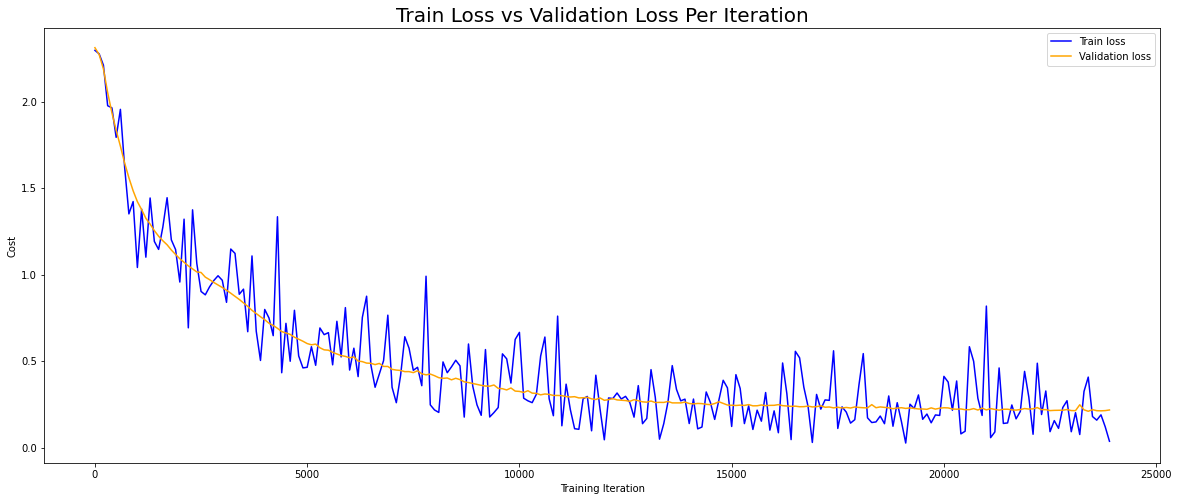

In [8]:
# plot cost vs training step
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[0], costs)), c='blue', label='Train loss')
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[1], costs)),  c='orange', label='Validation loss')
plt.title('Train Loss vs Validation Loss Per Iteration', size=20)
plt.xlabel("Training Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

Lastly, let's see the models performance on test set:

In [9]:
# Calculate test accuracy
print(f"Test accuracy: {(Predict(x_test, y_test, parameters, batchnorm) * 100):.4f}%")

Test accuracy: 93.8500%


### ***Part 5 - MNIST classification using our code with batchnorm and no dropout***

Using the code we wrote, let's classify the MNIST dataset:

##### ***Part 5.a - Loading and preprocessing MNIST data***

Fitst, let's load and preprocess the mnist data for our training:

In [10]:
# Load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train / 255
x_test =  x_test / 255

# Reshape images
x_train = x_train.reshape(x_train.shape[0], 784).T
x_test = x_test.reshape(x_test.shape[0], 784).T

# One hot encode labels
y_train = to_categorical(y_train, 10).T
y_test = to_categorical(y_test, 10).T

##### ***Part 5.b - MNIST classification with batchnorm and no dropout***

Next, let's train the model:

In [11]:
# Define model parameters
layer_dims = [x_train.shape[0], 20, 7, 5, 10]
learning_rate = 0.009
num_iterations = 100
batch_size = 32
batchnorm = True
dropout = False

# Train model
costs, parameters = L_layer_model(x_train, y_train, layer_dims, learning_rate,
                                  num_iterations, batch_size,
                                  validation_split=0.2, shuffle=True, 
                                  use_batchnorm=batchnorm,
                                  use_dropout=dropout)

Epoch (Training step) #1 | train_loss: 2.0288 - val_loss: 1.9248 | train_acc: 26.7229% - val_acc: 28.8167%
Epoch (Training step) #2 | train_loss: 1.9003 - val_loss: 1.8794 | train_acc: 28.2729% - val_acc: 28.0667%
Epoch (Training step) #3 | train_loss: 1.8539 - val_loss: 1.8186 | train_acc: 31.6042% - val_acc: 33.0000%
Epoch (Training step) #4 | train_loss: 1.7924 - val_loss: 1.7591 | train_acc: 32.6979% - val_acc: 34.3833%
Epoch (Training step) #5 | train_loss: 1.6605 - val_loss: 1.5252 | train_acc: 39.7313% - val_acc: 47.9583%
Epoch (Training step) #6 | train_loss: 1.3656 - val_loss: 1.2379 | train_acc: 57.5000% - val_acc: 63.7500%
Epoch (Training step) #7 | train_loss: 1.1698 - val_loss: 1.1090 | train_acc: 66.0312% - val_acc: 68.6083%
Epoch (Training step) #8 | train_loss: 1.0692 - val_loss: 1.0356 | train_acc: 69.8292% - val_acc: 71.1583%
Epoch (Training step) #9 | train_loss: 1.0047 - val_loss: 0.9809 | train_acc: 72.1375% - val_acc: 73.8000%
Epoch (Training step) #10 | train_los

Next, let's visualize the learning process (costs):

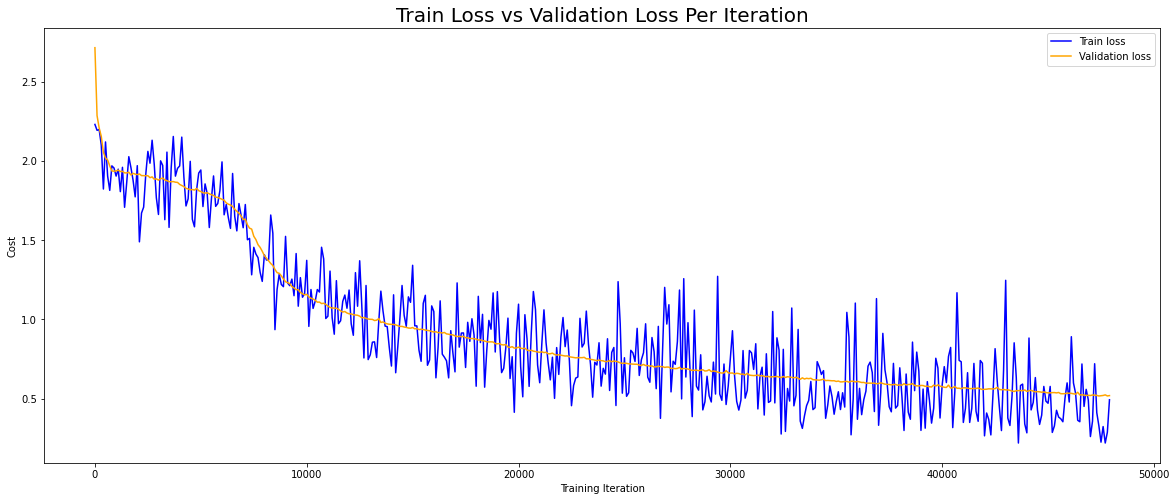

In [12]:
# plot cost vs training step
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[0], costs)), c='blue', label='Train loss')
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[1], costs)),  c='orange', label='Validation loss')
plt.title('Train Loss vs Validation Loss Per Iteration', size=20)
plt.xlabel("Training Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

Lastly, let's see the models performance on test set:

In [13]:
# Calculate test accuracy
print(f"Test accuracy: {(Predict(x_test, y_test, parameters, batchnorm) * 100):.4f}%")

Test accuracy: 87.8500%


### ***Part 6 - MNIST classification using our code with no batchnorm and with dropout***

Using the code we wrote, let's classify the MNIST dataset:

##### ***Part 6.a - Loading and preprocessing MNIST data***

Fitst, let's load and preprocess the mnist data for our training:

In [14]:
# Load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train / 255
x_test =  x_test / 255

# Reshape images
x_train = x_train.reshape(x_train.shape[0], 784).T
x_test = x_test.reshape(x_test.shape[0], 784).T

# One hot encode labels
y_train = to_categorical(y_train, 10).T
y_test = to_categorical(y_test, 10).T

##### ***Part 6.b - MNIST classification no batchnorm and with dropout***

Next, let's train the model:

In [15]:
# Define model parameters
layer_dims = [x_train.shape[0], 20, 7, 5, 10]
learning_rate = 0.009
num_iterations = 100
batch_size = 32
batchnorm = False
dropout = True

# Train model
costs, parameters = L_layer_model(x_train, y_train, layer_dims, learning_rate,
                                  num_iterations, batch_size,
                                  validation_split=0.2, shuffle=True, 
                                  use_batchnorm=batchnorm, use_dropout=dropout)

Epoch (Training step) #1 | train_loss: 2.1116 - val_loss: 1.8376 | train_acc: 30.8250% - val_acc: 44.6083%
Epoch (Training step) #2 | train_loss: 1.8559 - val_loss: 1.5369 | train_acc: 48.4458% - val_acc: 57.0667%
Epoch (Training step) #3 | train_loss: 1.6659 - val_loss: 1.3247 | train_acc: 60.2729% - val_acc: 60.7917%
Epoch (Training step) #4 | train_loss: 1.5416 - val_loss: 1.1659 | train_acc: 65.2042% - val_acc: 66.9000%
Epoch (Training step) #5 | train_loss: 1.4570 - val_loss: 1.0792 | train_acc: 67.9688% - val_acc: 70.1333%
Epoch (Training step) #6 | train_loss: 1.3883 - val_loss: 1.0095 | train_acc: 70.0146% - val_acc: 71.6667%
Epoch (Training step) #7 | train_loss: 1.3590 - val_loss: 0.9786 | train_acc: 71.7542% - val_acc: 73.3833%
Epoch (Training step) #8 | train_loss: 1.3175 - val_loss: 0.9409 | train_acc: 72.7271% - val_acc: 73.8083%
Epoch (Training step) #9 | train_loss: 1.3013 - val_loss: 0.9042 | train_acc: 73.3229% - val_acc: 72.9000%
Epoch (Training step) #10 | train_los

Next, let's visualize the learning process (costs):

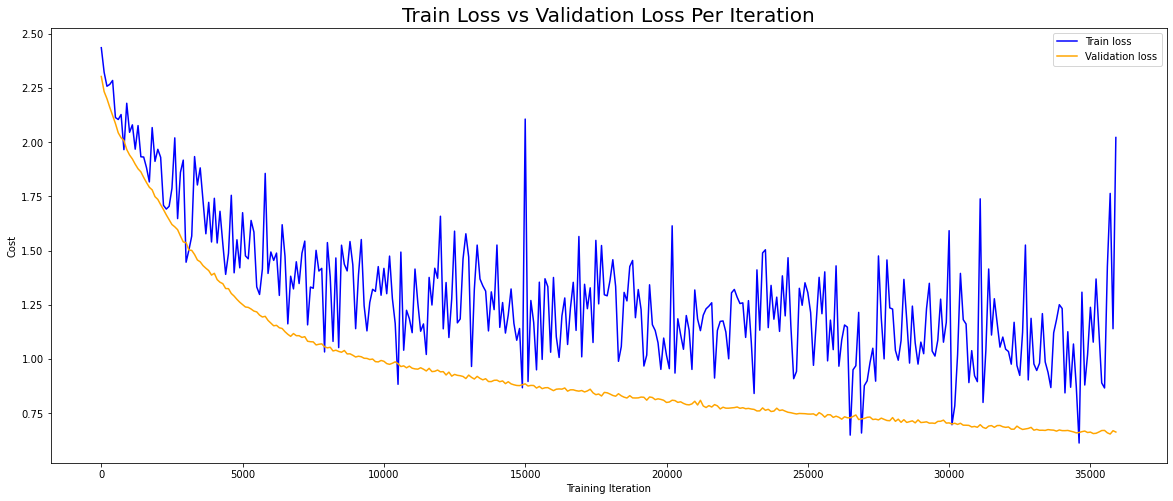

In [16]:
# plot cost vs training step
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[0], costs)), c='blue', label='Train loss')
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[1], costs)),  c='orange', label='Validation loss')
plt.title('Train Loss vs Validation Loss Per Iteration', size=20)
plt.xlabel("Training Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

Lastly, let's see the models performance on test set:

In [17]:
# Calculate test accuracy
print(f"Test accuracy: {(Predict(x_test, y_test, parameters, batchnorm) * 100):.4f}%")

Test accuracy: 85.8100%


### ***Part 7 - MNIST classification using our code with batchnorm and dropout***

Using the code we wrote, let's classify the MNIST dataset:

##### ***Part 7.a - Loading and preprocessing MNIST data***

Fitst, let's load and preprocess the mnist data for our training:

In [18]:
# Load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train / 255
x_test =  x_test / 255

# Reshape images
x_train = x_train.reshape(x_train.shape[0], 784).T
x_test = x_test.reshape(x_test.shape[0], 784).T

# One hot encode labels
y_train = to_categorical(y_train, 10).T
y_test = to_categorical(y_test, 10).T

##### ***Part 7.b - MNIST classification with batchnorm and dropout***

Next, let's train the model:

In [19]:
# Define model parameters
layer_dims = [x_train.shape[0], 20, 7, 5, 10]
learning_rate = 0.009
num_iterations = 100
batch_size = 32
batchnorm = True
dropout = True

# Train model
costs, parameters = L_layer_model(x_train, y_train, layer_dims, learning_rate,
                                  num_iterations, batch_size,
                                  validation_split=0.2, shuffle=True, 
                                  use_batchnorm=batchnorm, use_dropout=dropout)

Epoch (Training step) #1 | train_loss: 2.4481 - val_loss: 2.2995 | train_acc: 10.8542% - val_acc: 10.5500%
Epoch (Training step) #2 | train_loss: 2.3054 - val_loss: 2.1636 | train_acc: 13.2417% - val_acc: 21.6833%
Epoch (Training step) #3 | train_loss: 2.1560 - val_loss: 2.0335 | train_acc: 22.5104% - val_acc: 23.0000%
Epoch (Training step) #4 | train_loss: 2.0494 - val_loss: 1.9694 | train_acc: 23.4792% - val_acc: 23.8500%
Epoch (Training step) #5 | train_loss: 2.0018 - val_loss: 1.9177 | train_acc: 25.1917% - val_acc: 27.4250%
Epoch (Training step) #6 | train_loss: 1.9538 - val_loss: 1.8489 | train_acc: 28.5708% - val_acc: 28.4750%
Epoch (Training step) #7 | train_loss: 1.8970 - val_loss: 1.7865 | train_acc: 29.2458% - val_acc: 29.1833%
Epoch (Training step) #8 | train_loss: 1.8548 - val_loss: 1.7426 | train_acc: 29.9708% - val_acc: 30.1000%
Epoch (Training step) #9 | train_loss: 1.8275 - val_loss: 1.7220 | train_acc: 30.6521% - val_acc: 30.6083%
Epoch (Training step) #10 | train_los

Next, let's visualize the learning process (costs):

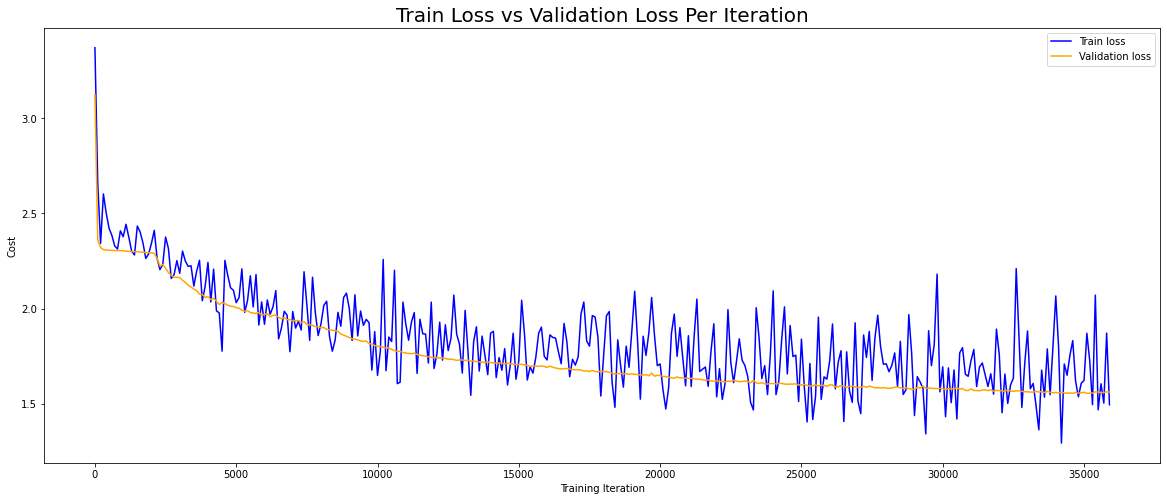

In [20]:
# plot cost vs training step
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[0], costs)), c='blue', label='Train loss')
plt.plot(list(range(0, len(costs) * 100, 100)),
         list(map(lambda x: x[1], costs)),  c='orange', label='Validation loss')
plt.title('Train Loss vs Validation Loss Per Iteration', size=20)
plt.xlabel("Training Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()

Lastly, let's see the models performance on test set:

In [21]:
# Calculate test accuracy
print(f"Test accuracy: {(Predict(x_test, y_test, parameters, batchnorm) * 100):.4f}%")

Test accuracy: 38.6900%
